In [1]:
reset -sf

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import math
import os
import re

import cv2

from sklearn.model_selection import train_test_split

In [4]:
from keras.models import Sequential
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

### Load Data and Pre-process

In [79]:
data_df = pd.read_csv('./data/driving_log.csv')

In [80]:
data_df.head(2)

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.14829
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.87963


In [5]:
def img2vec(X):
    '''
    Convert file name into pixel values
    '''
    for img in range(len(X)):
        for s in range(3):
            X[img][s] = mpimg.imread('./data/'+re.sub(r'[^\S\n\t]+', '', X[img][s]))
    return X

In [6]:
def load_data():
    """
    Load dataset from driving_log and split into training and validation set
    """
    data_df = pd.read_csv('./data/driving_log.csv')

    X = img2vec(data_df[['center', 'left', 'right']].values)
    y = data_df['steering'].values

    Xtr, Xval, ytr, yval = train_test_split(X, y, test_size=.2, random_state=0)

    return Xtr, Xval, ytr, yval

In [43]:
# main
Xtr, Xval, ytr, yval = load_data()

In [44]:
Xtr.shape, Xval.shape, ytr.shape, yval.shape

((6428, 3), (1608, 3), (6428,), (1608,))

In [7]:
# Take a random sample of images set, [center, left, right],and show
def plot_img(X):
    plt.figure(figsize=(18, 3))
    label = ['Center', 'Left', 'Right']
    random_int = random.randint(0, len(X))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(label[i], fontsize=15)
        img = X[random_int][i]
        plt.imshow(img)
    print('Index of IMG:', random_int,'\n' 'IMG Shape:', img.shape)

Index of IMG: 652 
IMG Shape: (160, 320, 3)


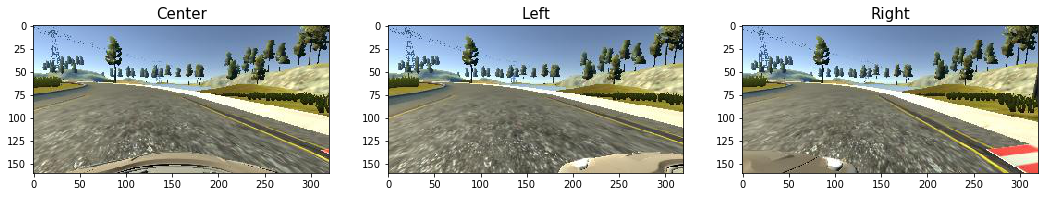

In [38]:
plot_img(Xtr);

* The top portion of the image captures trees and hills and sky, and the bottom portion of the image captures the hood of the car.

* During the model training, it might be faster if each image crop to focus on only the portion of the image that is useful for predicting a steering angle.

* In addition, the training images need to do pre-process into the best shape and color-type for NVIDIA model

In [8]:
def crop_resize_cvt2yuv(X):
    """
    Crop, resize, covert color in each image to remove sky at the top, and the hood of the car at the bottom
     - Crop: remove top 68, bottom 23 pixels
     - Resize: (160, 320, 3) -> (66, 200, 3), which is inout shape for NVIDIA model
     - Convert Color: RGB to YUV
    """
    for img in range(len(X)):
        for s in range(3):
            X[img][s] = cv2.cvtColor(cv2.resize(X[img][s][68: -23, :, :], (200, 66), cv2.INTER_AREA), cv2.COLOR_RGB2YUV)
    return X

In [46]:
# main
Xtr = crop_resize_cvt2yuv(Xtr)
Xval = crop_resize_cvt2yuv(Xval)

In [51]:
type(Xtr[0][0])

numpy.ndarray

Index of IMG: 2491 
IMG Shape: (66, 200, 3)


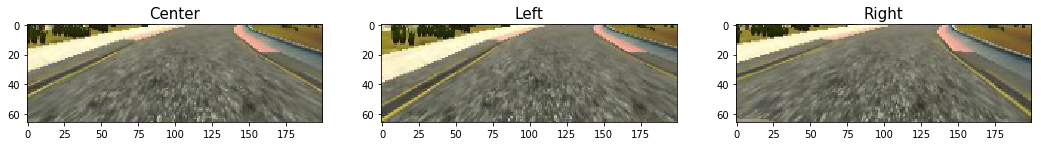

In [41]:
# crop and resize each image
plot_img(xxxx);

Index of IMG: 2998 
IMG Shape: (66, 200, 3)


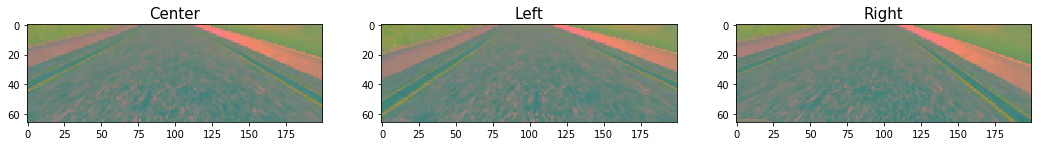

In [47]:
# crop, resize and convert color to YUV each image
plot_img(Xtr);

### Generate Images, propare for Train Set

In [9]:
'''
plotting count of steering angles for train and valid set
y: steering angle, float
'''
def plot_cnt(y, dataname):
    plt.figure(figsize=(18, 7))
    plt.hist(y, len(set(y)), edgecolor='black', linewidth=1.5)
    plt.axis('tight')
    plt.grid(linestyle='--')
    plt.title('Number of Class/Label in {0} Dataset'.format(dataname), fontsize=20)
    plt.xlabel('Steering Angle', fontsize=15)
    plt.ylabel('Number of Count', fontsize=15)
    print('Total Number of Dataset: {0}'.format(len(y)))

Total Number of Dataset: 6428


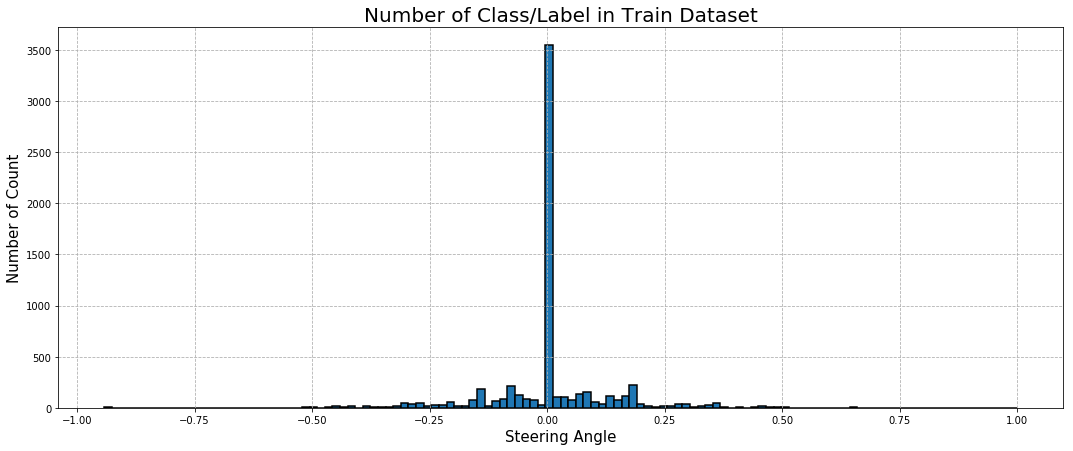

In [1330]:
plot_cnt(ytr, 'Train');

Total Number of Dataset: 1608


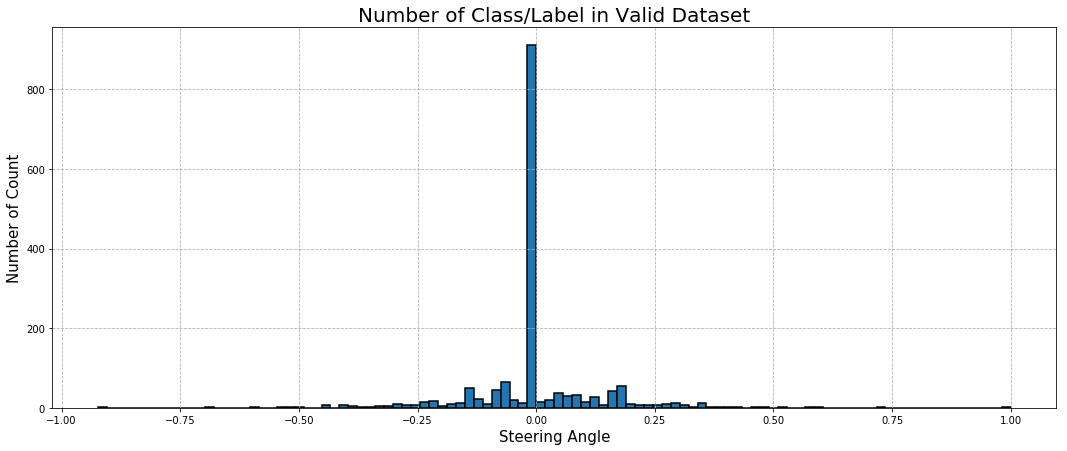

In [1331]:
plot_cnt(yval, 'Valid');

> The distribution of the data is skewed towards the low steering angles. This is because straight roads are usually a lot more than curved roads.<br>
It is necessary to make balanced dataset for training CNN model in order to get the best accuracy. <br>
In order to make balanced dataset, it requires some techniques such as image Flip and Tanslate.

In [10]:
def flip(img, angle):
    """
    The function flipt the image left <-> right, and adjust the steering angle.
    """
    if np.random.randint(-1, 1) < 0:
        #print('check')
        img = cv2.flip(img, 1)
        angle = -angle
    return img, angle

In [11]:
# def get_angle(p0, p1):
#     '''
#     The function calculate the angle based on translate point
#     p0(tuple): original point, (100, 66) == (x, y)
#     p1(tuple): traslated point
#     '''
#     x1, y1 = p0
#     x2, y2 = p1
#     dx = x2 - x1
#     dy = y2 - y1
#     rads = math.radians(90) - math.atan2(-dy, dx)
#     return rads

In [12]:
def translate(img, angle):
    """
    The function makes translating images in random (X, Y) coordinate, between -30.0 and 30.0 for x
                                                                       between -5.0 and 5.0 for y
    And adjust the steering angle 
    """
    #p0 = (100, 66)
    y, x = img.shape[:2]
    tx = np.random.uniform(-30., 30.)
    ty = np.random.uniform(-5., 5.)
    #p1 = (100+tx, 66+ty)
    #angle = get_angle(p0, p1)
    angle += tx * 0.003
    trans_M = np.float32([[1, 0, tx], [0, 1, ty]])
    trans_img = cv2.warpAffine(img, trans_M, (x, y))
    return trans_img, angle

In [1335]:
i0, a0 = flip(Xtr[20][0], ytr[20])

Steering Angel: -0.3009732
YUV Image: (66, 200, 3)


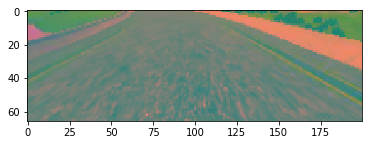

In [1342]:
print('Steering Angel:', a0)
print('YUV Image:',i0.shape)
plt.imshow(i0);

In [1344]:
i1, a1 = translate(Xtr[20][0], ytr[20])

Steering Angel: 0.248722350927
YUV Image: (66, 200, 3)


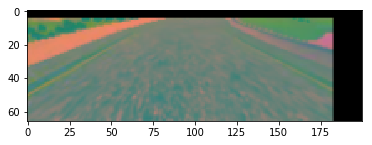

In [1345]:
print('Steering Angel:', a1)
print('YUV Image:',i1.shape)
plt.imshow(i1);

0.3009732


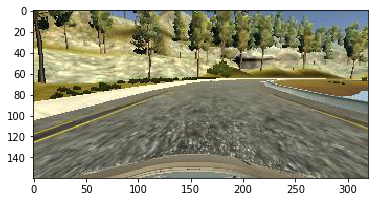

In [664]:
print(ytr[20])
plt.imshow(Xtr[20][0]);

In [13]:
def adjust_gamma(img, angle):
    """
    The function adjust gamma value to change brightness of image
    opencv provides Color map, but changing only brighness with gamma needs to make own color map
    The table is from Google search, mapping the pixel values [0, 255] to adjust gamma values
    """
    gamma = np.random.uniform(0.3, 3.)
    invGamma = 1.0 / gamma
    color_map = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
 
    # apply gamma correction using the color_map
    return cv2.LUT(img, color_map), angle

In [1347]:
i2, a2 = adjust_gamma(Xtr[20][0], ytr[20])

Steering Angel: 0.3009732
YUV Image: (66, 200, 3)


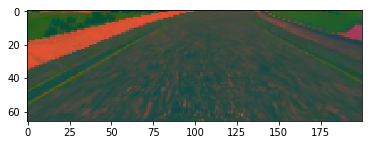

In [1348]:
print('Steering Angel:', a2)
print('YUV Image:',i2.shape)
plt.imshow(i2);

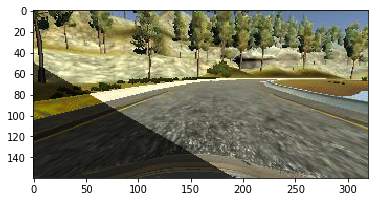

In [837]:
plt.imshow(i42);

In [14]:
def shadowing(img, angle):
    """
    The function makes shodow on the images in randomly choosed locations
    Mask: Above the line will be (ym-y1)/(xm-x1) > (y2-y1)/(x2-x1)
    Since x2 == x1 causes zero-division problem, it needs to make this form (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
    """
    x1, x2 = 200 * np.random.uniform(-1., 1., 2)
    y1, y2 = 0, 66
    xm, ym = np.mgrid[:66, :200]            # make np.array for grid, location of pixles, on the image
    mask = np.zeros_like(img[:, :, 1])
    mask[(ym-y1) * (x2-x1) - (y2-y1) * (xm-x1) > 0] = 1

    # Randomly choose the side, which above/below of the line, has shadow and adjust saturation
    side = mask == np.random.randint(0, 2)
    ratio = np.random.uniform(0.0, 0.3)

    # Adjust Saturation in YUV(Y: brightness of the color)
    img[:,:,0][side] = img[:,:,0][side] * ratio
    return img, angle

In [1380]:
i3, a3 = shadowing(Xtr[150][0], ytr[150])

Steering Angel: 0.01391724
YUV Image: (66, 200, 3)


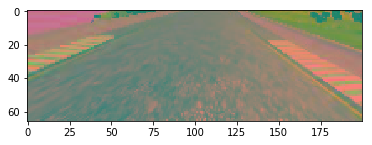

In [1379]:
print('Steering Angel:', ytr[150])
print('YUV Image:',Xtr[150][0].shape)
plt.imshow(Xtr[150][0]);

Steering Angel: 0.01391724
YUV Image: (66, 200, 3)


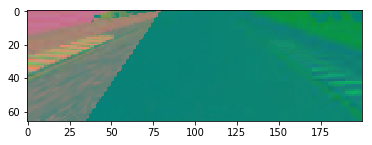

In [1381]:
print('Steering Angel:', a3)
print('YUV Image:',i3.shape)
plt.imshow(i3);

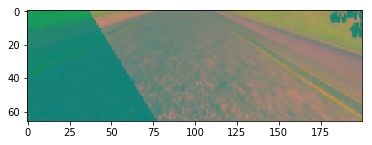

In [1105]:
# 0.2
plt.imshow(test);

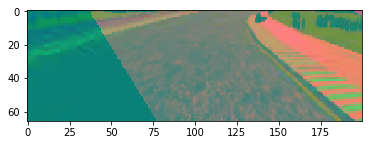

In [1102]:
#0.1
plt.imshow(test);

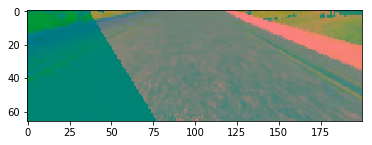

In [1099]:
#0.0
plt.imshow(test);

In [25]:
def generator(X, y, batch_size, train=1):
    """
    The function generate training images, and make training set with batch_size
    In order to generate images, it needs to various of techniques: flip, translation, a 
    """
    imgSet = np.empty([batch_size, 66, 200, 3])
    angleSet = np.empty(batch_size)
    ### print(imgSet.shape, angleSet.shape)
    while True:
        for idx in np.random.permutation(X.shape[0]):
            n=0
            img, angle = X[idx], y[idx]
            
            '''
            Image Argumentation: 
                - Randomly choose from ['center', 'left', 'right'] images in weight of [0.3, 0.35, 0.35]
                  because distribution of images skewed with straight roads (steering angle == 0.0),
                  so choosing left(steering angle += 0.2) and right(steering angle -= 0.2) in higher rate
                  might help to figure out unblanced input data
                - Making curved images because the images with angle = 0 (straight roads) are enough
                -   
            '''  
            if train:
                l = np.random.choice(['center', 'left', 'right'], p=[0.3, 0.35, 0.35])
                if l == 'center':
                    img, angle = img[0], angle
                elif l == 'left':
                    img, angle = img[1], angle + 0.2         # left side of image has different angle, +0.2 
                else: 
                    img, angle = img[2], angle - 0.2         # right side of image has different angle, -0.2


                if np.random.randint(0, 5) < 4:     # about 80% chance 
                    ran_gen = np.random.choice([flip, translate, shadowing, adjust_gamma])
                    img, angle = ran_gen(img, angle)
            
            else:
                img, angle = img[0], angle

                
            # add the image and steering angle to the batch
            imgSet[n] = img
            angleSet[n] = angle
            
            n+=1
            if n == batch_size:
                break
            
        yield imgSet, angleSet

In [26]:
def bulid_model():
    '''
    Using NVIDIA model
    '''
    model = Sequential()
    
    # Input Normalize - to avoid saturation and make gradients work better
    model.add(Lambda(lambda x: x/127.5 - 1.0, input_shape=(66, 200, 3)))
    
    # Add Convolution, Conv2D, layers
    # Apply ELU(Exponential linear unit) function, to take care Vanishing gradient problem
    # Conv2D(output depth, kernel_low, kernel_column, activation_func., subsample=(stride))
    model.add(Conv2D(24, 5, 5, activation='elu', subsample=(2, 2)))
    model.add(Conv2D(36, 5, 5, activation='elu', subsample=(2, 2)))
    model.add(Conv2D(48, 5, 5, activation='elu', subsample=(2, 2)))
    model.add(Conv2D(64, 3, 3, activation='elu', subsample=(1, 1)))
    model.add(Conv2D(64, 3, 3, activation='elu', subsample=(1, 1)))
    model.add(Dropout(0.5))         # To avoid overfitting
    
    # Add Fully-Connected layers
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))
    model.summary()
    
    return model

In [30]:
# main
model = bulid_model()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_3 (Lambda)                (None, 66, 200, 3)    0           lambda_input_3[0][0]             
____________________________________________________________________________________________________
convolution2d_11 (Convolution2D) (None, 31, 98, 24)    1824        lambda_3[0][0]                   
____________________________________________________________________________________________________
convolution2d_12 (Convolution2D) (None, 14, 47, 36)    21636       convolution2d_11[0][0]           
____________________________________________________________________________________________________
convolution2d_13 (Convolution2D) (None, 5, 22, 48)     43248       convolution2d_12[0][0]           
___________________________________________________________________________________________

In [22]:
def training(model, Xtr, Xval, ytr, yval):
    """
    The function train the NVIDIA model
    """
    checkpoint = ModelCheckpoint('model.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='auto')

    model.compile(loss='mse', optimizer=Adam(lr=1e-4))
    
    model.fit_generator(generator(Xtr, ytr, 40),
                        samples_per_epoch=len(Xtr)*10,
                        nb_epoch=30,
                        max_q_size=1,
                        validation_data=generator(Xval, yval, 40, 0),
                        nb_val_samples=len(Xval),
                        callbacks=[checkpoint],
                        verbose=1)

In [27]:
def main():
    Xtr, Xval, ytr, yval = load_data()
    Xtr = crop_resize_cvt2yuv(Xtr)
    Xval = crop_resize_cvt2yuv(Xval)
    
    model = bulid_model()
    training(model, Xtr, Xval, ytr, yval)

In [ ]:
if __name__ == '__main__':
    main()